# Analysis of brainstorming annotations: Between-Groups Study
The following is an analysis based on the sketch annotations collected from a total of 18 teams.
9 of the teams performed what is called "free" brainstorming, while then remaining 9 performed an alternating divergent-convergent process.
We had earlier attempted a semantic analysis of their transcript, separating the convergent and divergent processes.
We now analyze all annotations collected from the team sketches.

## Data Collection
While a semantic network analysis is not very straightforward to do when it comes to annotations (there are no sentences, and word co-occurrence is thus a difficult concept to establish).
We thus define word co-occurrence as words that describe different parts of the same idea.
In most cases, this means that words that appear on the same sketch are treated as part of the same "sentence".
In other cases, we combined words that clearly and unambiguously described the same idea or class of ideas.

## Code Credits
A lot of this code is inspired from, and in several cases reused directly from the code written by Moses Boudourides, Sergios Lenis & Pantelis Vikatos. Their version can be seen at: http://mboudour.github.io/2016/03/22/Clinton-Sanders-Word-Nets.html

We change some aspects of the commonality functions and co-occurrence functions to suit our requirements, see code comments that accompany these functions below for details.

In [2]:
# Get all imports out of the way
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk.corpus import stopwords
from nltk.corpus.reader.wordnet import information_content
from nltk.tokenize import sent_tokenize
import itertools
import codecs
import re
import pprint as pp
import operator
from collections import OrderedDict
from collections import Counter
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Step 1: Read Files
We first read the file that contains all annotations from the "Free Brainstorming" group.

In [4]:
filePath = "../../../private/brainstorming_viz_data/free_group/"
fileName = "free_teams_sketch_concepts.txt"
with open(filePath + fileName) as fObj:
    freeFileContent = fObj.read()
    
freeGroupAnnotations = freeFileContent.split("\n")

## Step 2: Tokenizing and stop word removal
Splitting the annotations into individual words, we remove "stop words" -- common words that add little meaning, such as articles, pronouns, prepositions etc. An added step would be to then "lemmatize" the resulting words so that words such as "short", "shorter", and "shortest" are treated the same (short), and words with different tenses, singular/plural forms etc. are also treated the same. However, we will do this at a later stage so that we can first identify all occurrences of the filtered words in the original text. To do this, we will need to implement whole-word matches, which will not be accurate if we were to lemmatize first.

In [5]:
freeGroupWords = nltk.word_tokenize(freeFileContent)
freeWordsFiltered = [w for w in freeGroupWords if not w in stopwords.words('english')]
freeDiff = len(freeGroupWords) - len(freeWordsFiltered)
print(freeDiff, "stop words removed from a total of", len(freeGroupWords), "words in the free Group")

279 stop words removed from a total of 2222 words in the free Group


In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
wnL = WordNetLemmatizer()
ps = PorterStemmer()

# We use this function for Lemmatization, but will try it out later.
# Right now let's just go with filtering by unique words.
def genLemma(wordList):
    lemmaList = []
    for word in wordList:
        synsets = wn.synsets(word)
        if len(synsets) > 0:
            synset = synset[0]
            sName = synset.name().split('.')[0]
            sPos = synset.pos()
            wordLemma = wnL.lemmatize(sName, pos=sPos)
            lemmaList.append(wordLemma)
    return LemmaList

freeWordsLemmU = list(set(freeWordsFiltered))
print("Words in the Free Group reduced to", len(freeWordsLemmU), "unique occurrences.")

Words in the Free Group reduced to 727 unique occurrences.


## Step 4: Partition based on Information Content
As we can see, the resulting list of words is rather large and unmanageable. We "rank" these words based on information content.
Information content is a measure of how important a word is, and it depends on the likelihood of finding a word in a text corpus, i.e.

$$IC(w) = -log(P(w)) $$

After iterating through all the text corpora available in WordNet, we settle on the British National Corpus as most suitable for our dataset, as it has the largest overlap with our dataset.

##### NOTE: 
For this version, we compute information conent, but do not attempt any of the above partitioning.

In [7]:
def getInfoContent(wordList, corpus):
    tokens = []
    icArray = []
    nonicArray = []
    for token in wordList:
        tempNum = 0
        synsets = wn.synsets(token)
        if len(synsets) > 0:
            for synset in synsets:
                if not set([synset.pos()]).intersection(set(['a','s','r'])) :
                    synsetItem = synset
                    tempNum = 1
                    break
            if tempNum == 1:
                infoContent = information_content(synsetItem, corpus)
                icArray.append((token, infoContent))
            else :
                nonicArray.append(token)
    icDict = dict(icArray)
    icTuple = sorted(icDict.items(), key=operator.itemgetter(1),
                     reverse=True)
    return [OrderedDict(icTuple), nonicArray]

corpusName = 'ic-bnc-add1'
ic_corpus = wordnet_ic.ic(corpusName + '.dat')
print("Computing infocontent with ",corpusName," corpus...", end="")
freeGroupProcessed = getInfoContent(freeWordsLemmU, ic_corpus)
print("done.")
freeGrpInfoContents = freeGroupProcessed[0]
freeGrpNonInfoContents = freeGroupProcessed[1]
freeGrpFrequencies = Counter(freeWordsFiltered)
pp.pprint(freeGrpFrequencies)
print("Number of words in the Free Group that could have infocontent computed:", len(freeGrpInfoContents))
print("Number of words in the Free Group that could NOT have infocontent computed:", len(freeGrpNonInfoContents))

Computing infocontent with  ic-bnc-add1  corpus...done.
Counter({',': 321,
         '.': 231,
         'water': 29,
         'final': 27,
         'concept': 27,
         'toy': 24,
         'ball': 17,
         'game': 15,
         'wind': 15,
         'car': 12,
         'gun': 12,
         '/': 11,
         'catapult': 10,
         'moves': 10,
         'motion': 10,
         ')': 9,
         '(': 9,
         'air': 9,
         'spring': 9,
         'pump': 9,
         'launcher': 8,
         'rubber': 8,
         'wheels': 8,
         'control': 7,
         'plane': 7,
         'maze': 7,
         'flying': 7,
         'shooting': 7,
         'wind-up': 6,
         'back': 6,
         'boat': 6,
         'cannon': 6,
         'top': 6,
         'loaded': 5,
         'forward': 5,
         'hand': 5,
         '-': 5,
         'pieces': 5,
         'rc': 5,
         'toys': 5,
         'button': 5,
         'marble': 5,
         'bike': 5,
         'around': 5,
         'motor': 5,
 

## Step 5: Remove irrelevant words##
This step is to be performed only after generating a co-occurrence network first. Exploring the interactive network shown at Step 7 below allows us to identify words that add more noise than information to the graph. This is, of course, subjectively determined. These words are removed from consideration in the procedure below.

In [8]:
# Noun phrases that can be removed:
to_be_removed = [',', '.', '/', ')', '(', '-', '2', '?', '1', '10', ':',
                 '5', '!', '15', '4.', '10.', '``', "n't", '=', "''", "'s", 
                 '1.', '+', '16', '4']

keys_to_delete = []
for key in freeGrpFrequencies.keys():
    if key in to_be_removed:
        keys_to_delete.append(key)
for key in keys_to_delete:
    del freeGrpFrequencies[key] # could not have deleted item from iterable 
                    # from within the loop
filteredWords=freeGrpFrequencies.keys()
print("Number of common words in the top third after filtering:", len(filteredWords))

Number of common words in the top third after filtering: 702


## Step 5: Identify co-occurrences
We go over each sentence in the original dataset and look for word co-occurrences; pairs of words that occur in the same sentence. This helps us draw a concept map for each group's divergent brainstorming transcript data.

In [9]:
# That function will in turn call the below regexp to find whole words.
def findWholeWord(w):
    # regular expression to find whole words
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

def findOccurs(sentences, terms):
    # First find occurrences of every term in every sentence
    termOcc = []
    for ind, term in enumerate(terms):
        # search for term in all sentences.
        termData = [term, []]
        for sent in sentences:
            match = findWholeWord(term)(sent)
            if match :
                    termData[1].append(sent)
        if len(termData[1]) > 0:
            termOcc.append(termData)
    # Each entry in termOcc is now of the kind [term, [sent1, sent2,...]]
    # Now, to iterate through the termOcc list to find co-occurrences
    print("Term occurrences computed. Finding term co-occurrences...")
    occurdict = {}
    contextdict = {}
    for ind, termData in enumerate(termOcc):
        # search only through the REST of the list (to prevent repeat
        # counts)
        for cotermData in termOcc[ind+1:]:
            # NOTE : termData and coTermData are of type [term, [s1, s2,...]]
            for sent in termData[1]:
                match = findWholeWord(cotermData[0])(sent)
                if match :
                    wordkey = termData[0]+" - "+cotermData[0]
                    if wordkey in contextdict:
                        contextdict[wordkey] = contextdict[wordkey] + [sent]
                    else :
                        contextdict[wordkey] = [sent]
                    if wordkey in occurdict:
                        occurdict[wordkey] = occurdict[wordkey] + 1
                    else :
                        occurdict[wordkey] = 1
    return (occurdict, contextdict)

g1sentences = freeGroupAnnotations
pp.pprint(g1sentences)
freeCooccur, freeContext= findOccurs(g1sentences, filteredWords)
print("Number of unique co-occurrences found in the Free Group:", len(freeCooccur))

['swivel wheels, shooting ball, shooting gorilla bike rider, final concept',
 'swivel wheels, shooting balls, shooting gorilla bike rider, final concept '
 'gorilla.',
 'gorilla pedals tricycle, final concept, gun shoots from both sides.',
 'final concept, cannon.',
 'row, shark tail.',
 'crap rower.',
 'dragon shooter in jack-in-the-box.',
 'marble run with self-start.',
 'wind-up, moves forward.',
 'pin ball machine, strong magnet.',
 'water, walking under water crab.',
 'rowing water toy.',
 'toy reads book, page turned automatically, book.',
 'rotating head, swing arms.',
 'refrigerator, magnet, can you make it stick?',
 'flying disc, spins, frisbee disc.',
 'moving ape, swing arms.',
 'closest/furthest object, swivels, rc cart.',
 'army men football.',
 'electronic chess, app.',
 'moving army man game.',
 'catapult candy dispenser, candy dispenser.',
 'tracking marker on tripod.',
 'gun with catcher.',
 'cleaning top.',
 'hair lights up, arm moves up and down, target customer ages

## Step 6: Plot word co-occurrence for the Free Brainstorming group
We use the data obtained in step 6 to plot a graph of co-occurrences in the "free brainstorming" group.
#### NOTE
We do not plot the graph as it takes up too much of the available resources, and is illegibly dense. We instead focus on obtaining the community partitions.

In [10]:
# Function to construct a graph of common noun phrases tied by 
# their co-occurrences in sentences of a transcript
def makegraph(occurrences):
    G = nx.Graph()
    weights = []
    for edgs,wt in occurrences.items():
        edg = edgs.split(' - ')
        G.add_edge(edg[0], edg[1], weight=wt)
        G.add_node(edg[0], label=edg[0])
        G.add_node(edg[1], label=edg[1])
        weights.append(wt)
    return [G, weights]

FreeGraphData = makegraph(freeCooccur)
GFree = FreeGraphData[0]
FreeEdges = FreeGraphData[1]

In [11]:
from networkx.drawing.nx_agraph import graphviz_layout
from bokeh import mpl
from bokeh.plotting import output_notebook, show, figure
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

# First, create a graph layout
pos = nx.spring_layout(GFree, iterations=20)

def draw_interactive_network(graphObj, positions, wordFreq, wordCooccurs, wordContext, graphTitle):
    # Redrawing the graph from scratch so that the network may be interactive
    # NOTE: The current interactions are:
    # Hover on a node to show corresponding word's occurrences in the text
    # Hover on an edge center to show:
    #    * Number of co-occurrences that the edge indicates
    #    * The context, i.e., sentences in which the words co-occur.
    
    # Then obtain locations and metadata of the nodes from this layout
    xlocs = []
    ylocs = []
    nodeLabels = []
    nodeFreq = []
    nodeSizes = []
    for i in positions:
        nodeLabels.append(i)
        nodeFreq.append(str(wordFreq[i])+" occurrence(s)")
        nodeSizes.append(wordFreq[i]+10)
        xlocs.append(positions[i][0])
        ylocs.append(positions[i][1])

    # The eventual goal ofcontextHTML is to convert contextdict values 
    # from lists to html list items.
    # However, bokeh.js currently does not handle html tags *inside* variables.
    # Curently using the slightly ugly "||||" separator below
    contextHTML = {}
    for i in wordContext:
        conList = wordContext[i]
        conHTML = ""
        for item in conList:
            conHTML = conHTML + " " + item+" ||||"
        contextHTML[i] = conHTML.rstrip("|")

    # obtain locations and metadata of the edges from the layout
    edgeXpairs = []
    edgeYpairs = []
    edgeLabels = []
    edgeMidPtX = []
    edgeMidPtY = []
    edgeFreq = []
    edgeW = []
    edgeContext = []
    edgeListNames = wordCooccurs.keys()
    for i in graphObj.edges():
        w1 = i[0]
        w2 = i[1]
        w1x, w1y = positions[w1]
        w2x, w2y = positions[w2]
        edgeXpairs.append([w1x, w2x])
        edgeYpairs.append([w1y, w2y])
        edgeLabels.append(w1+" & "+w2)
        edgeMidPtX.append((w1x + w2x)/2)
        edgeMidPtY.append((w1y + w2y)/2)
        edgeString = w1 + ' - ' + w2
        edgeStringRev = w2 + ' - '+ w1
        if (edgeString in edgeListNames):
            edgeFreq.append(str(wordCooccurs[edgeString])+" co-occurrence(s)")
            edgeW.append(wordCooccurs[edgeString])
            edgeConString = contextHTML[edgeString]
            edgeContext.append(edgeConString)
        else :
            edgeFreq.append(str(wordCooccurs[edgeStringRev])+" co-occurrence(s)")
            edgeW.append(wordCooccurs[edgeStringRev])
            edgeConString = contextHTML[edgeStringRev]
            edgeContext.append(edgeConString)


    # Create a ColumnDataSource for the hover tool to reference
    dataPoints = dict(x = (xlocs + edgeMidPtX),
                      y = (ylocs + edgeMidPtY),
                      occ = (nodeFreq + edgeFreq),
                      desc = (nodeLabels + edgeLabels),
                      vis = ([1.0 for x in nodeLabels] + [0.0 for x in edgeLabels]),
                      size = (nodeSizes + [15 for x in edgeLabels]),
                      cxt = (["" for x in nodeLabels] + edgeContext))

    interact = ColumnDataSource(data = dataPoints)

    hover_data = HoverTool(tooltips ="""
                                   <text style="font-size: 17px; font-weight: bold;">@desc</text>
                                   <br>
                                   <text style="font-size: 15px">@occ</text>
                                   <div style="width:300px;font-size: 11px; font-face='Courier'">
                                       @cxt
                                   </div>
                                   """,
                                   point_policy='snap_to_data')

    p = figure(title = graphTitle, width=900, height=900)
    p.multi_line(edgeXpairs, edgeYpairs, color='gray', alpha=0.4, line_width=edgeW)
    p.circle('x', 'y', size='size', fill_color='#fed9a6', line_color=None, alpha='vis', source=interact)
    p.text(xlocs, ylocs, nodeLabels, text_font="Roboto", text_color='#333333', text_font_size='11pt', 
           text_align='center', text_baseline='middle' )

    p.add_tools(hover_data)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.visible = None
    show(p)

# draw_interactive_network(GFree, pos, freeGrpFrequencies, freeCooccur, freeContext, 
#                          "Co-occurrences in the Free Brainstorming Group")

Loading BokehJS ...

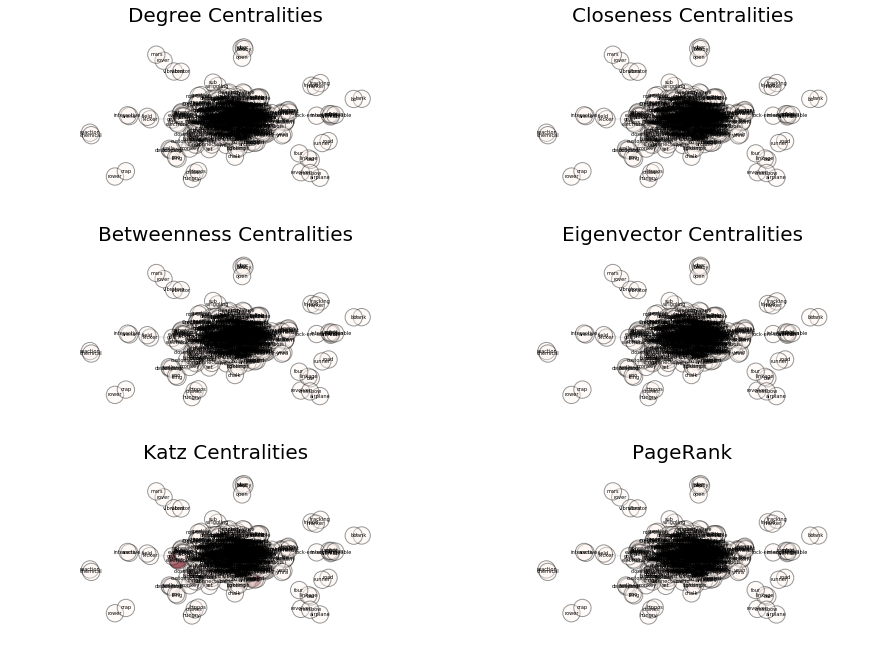

In [12]:
%matplotlib inline
from tools import draw_centralities_subplots
centrali1=draw_centralities_subplots(GFree, pos, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

## Step 7: Identify Communities ##
Here communities are nothing but partitions that can be made to the network. The community identification is performed using the [Louvain method](http://arxiv.org/pdf/0803.0476.pdf). Python has an [implementation of the algorithm](http://perso.crans.org/aynaud/communities/) as part of the NetworkX library.

For details refer "tools.py" in the parent directory. Identifying these partitions can help us identify "themes" to each group's transcripts, helping us understand the group's behavior better.

In [42]:
# detecting communities of common phrases
%reload_ext autoreload
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
sstt = "Co-occurrences in the Free Brainstorming Group"
part, nodper = print_communities(GFree, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=0.15
vcc={}

sstta="The Free group's convergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GFree,GFree.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=12,valpha=0.25)

Number of communities of  Co-occurrences in the Free Brainstorming Group  =  26
Community partition of  Co-occurrences in the Free Brainstorming Group :
[['waist',
  'somehow',
  'coil',
  'starts',
  'bath',
  'heavy',
  'spins',
  'toy',
  'submarine',
  'level',
  'spin',
  'shower',
  'plastic',
  'flick',
  'amphibious',
  'system',
  'let',
  'rowing',
  'fly',
  'dorm',
  'light-weight',
  'room',
  'helical',
  'hover',
  'tire',
  'tub',
  'angular',
  'unique',
  'body',
  'weight',
  'develop',
  'disc',
  'oscillating',
  'desk',
  'helicopter',
  'diver',
  'office',
  'string',
  'go',
  'changes',
  'able',
  'momentum',
  'compartmental',
  'position',
  'rocker',
  'navy',
  'entry',
  'shaft',
  'floating',
  'multifunction',
  'perfect',
  'payload',
  'modular',
  'splash',
  'duck',
  'pull',
  'spring',
  'dismantle-able',
  'loaded',
  'wind-up',
  'men',
  'propeller',
  'drag'],
 ['randomly',
  'swimming',
  'train',
  'usa',
  'Pac',
  'cherry',
  'led',
  'tr